In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

### **1. Loading Data**

In [27]:
df = pd.read_csv('../Data/laptopPrice.csv')

In [28]:
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


In [29]:
print(df.shape)

(823, 19)


### **2. Data Checks**
- Checking missing values
- Checking duplicates
- Checking data types of each column
- Checking the number of unique values of each column
- Checking statistics of data set
- Checking various categories present in different categorical column

In [30]:
df.isna().sum()

brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd                  0
hdd                  0
os                   0
os_bit               0
graphic_card_gb      0
weight               0
warranty             0
Touchscreen          0
msoffice             0
Price                0
rating               0
Number of Ratings    0
Number of Reviews    0
dtype: int64

In [31]:
df.duplicated().sum()

21

In [32]:
df = df.drop_duplicates()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802 entries, 0 to 822
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   brand              802 non-null    object
 1   processor_brand    802 non-null    object
 2   processor_name     802 non-null    object
 3   processor_gnrtn    802 non-null    object
 4   ram_gb             802 non-null    object
 5   ram_type           802 non-null    object
 6   ssd                802 non-null    object
 7   hdd                802 non-null    object
 8   os                 802 non-null    object
 9   os_bit             802 non-null    object
 10  graphic_card_gb    802 non-null    object
 11  weight             802 non-null    object
 12  warranty           802 non-null    object
 13  Touchscreen        802 non-null    object
 14  msoffice           802 non-null    object
 15  Price              802 non-null    int64 
 16  rating             802 non-null    object
 1

In [34]:
df.nunique()

brand                  8
processor_brand        3
processor_name        11
processor_gnrtn        8
ram_gb                 4
ram_type               6
ssd                    7
hdd                    4
os                     3
os_bit                 2
graphic_card_gb        5
weight                 3
warranty               4
Touchscreen            2
msoffice               2
Price                405
rating                 5
Number of Ratings    282
Number of Reviews    135
dtype: int64

In [35]:
df.describe()

,Price,Number of Ratings,Number of Reviews
count,802.000000,802.00000,802.000000
mean,76625.543641,299.84414,36.089776
std,45232.984422,1001.78442,118.313553
min,16990.000000,0.00000,0.000000
25%,45990.000000,0.00000,0.000000
50%,63990.000000,17.00000,2.000000
75%,89525.000000,140.25000,18.000000
max,441990.000000,15279.00000,1947.000000


#### **Insights**
- There are some outliers in all the 3 numerical columns
- No missing values in the dataset

In [36]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'object']
cat_features = [feature for feature in df.columns if df[feature].dtype == 'object']
print("Numerical features: ", numeric_features)
print("Categorical featues:", cat_features)

Numerical features:  ['Price', 'Number of Ratings', 'Number of Reviews']
Categorical featues: ['brand', 'processor_brand', 'processor_name', 'processor_gnrtn', 'ram_gb', 'ram_type', 'ssd', 'hdd', 'os', 'os_bit', 'graphic_card_gb', 'weight', 'warranty', 'Touchscreen', 'msoffice', 'rating']


### **3. Data Visualization**

#### 3.1 Histograms

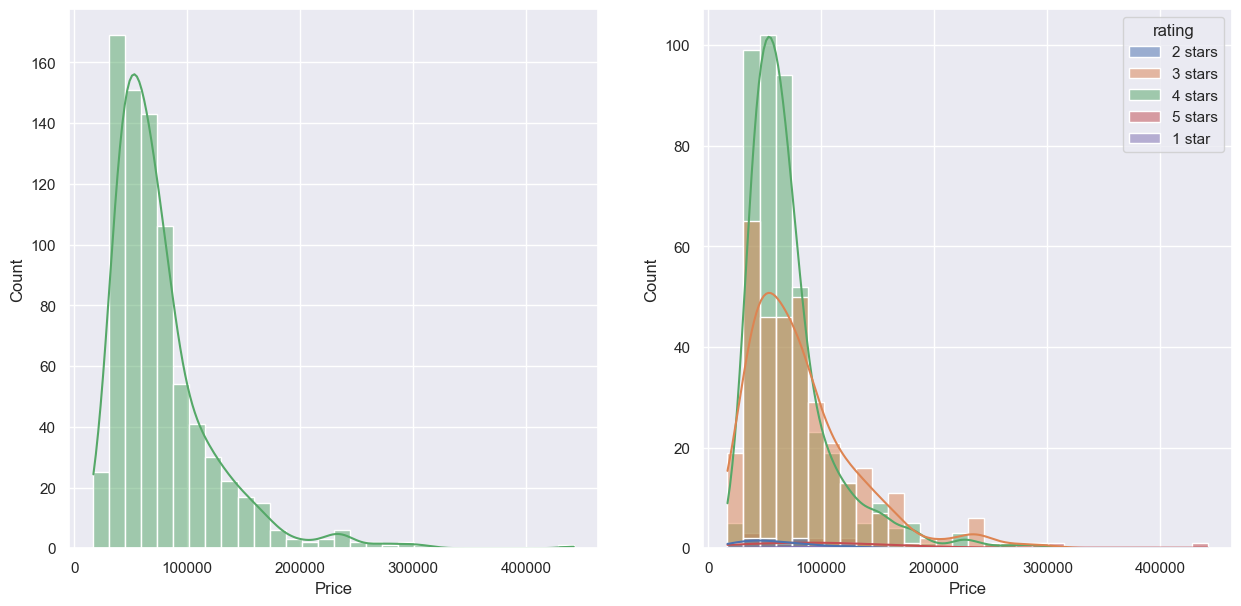

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x= 'Price', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x= 'Price', bins=30, kde=True, color='g', hue= 'rating')
plt.show()

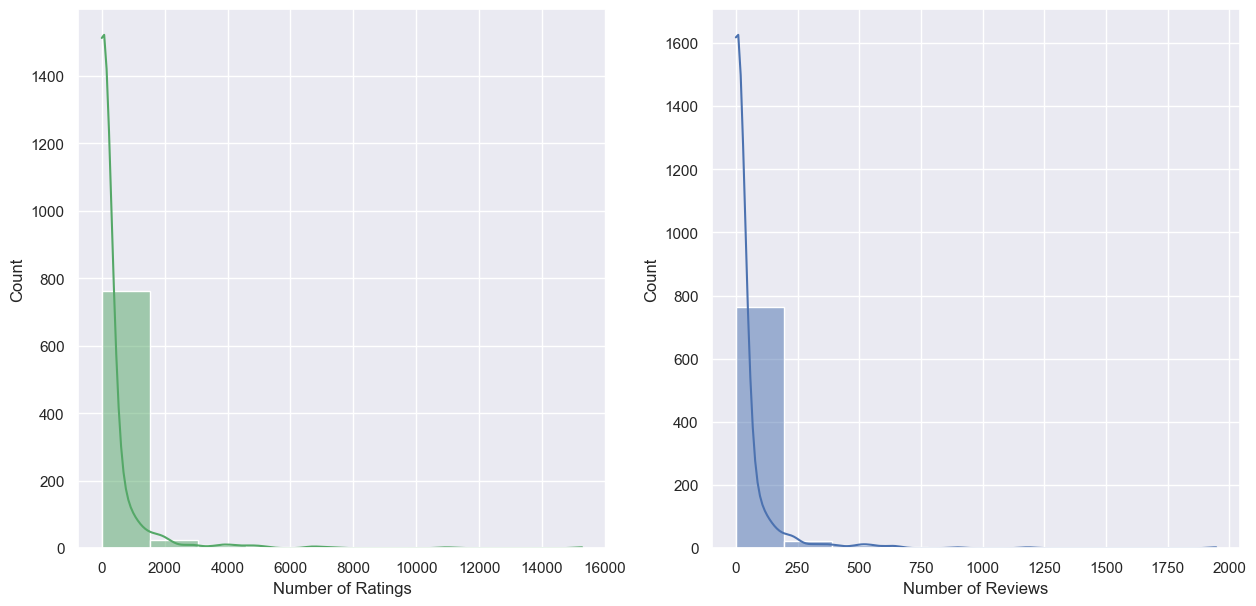

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df,x='Number of Ratings',bins=10,kde=True,color='g')
plt.subplot(122)
sns.histplot(data=df,x='Number of Reviews',kde=True, bins = 10)
plt.show()

In [192]:
def remove_outliers(df, column):
    percentile25 = df[column].quantile(0.25)
    percentile75 = df[column].quantile(0.75)
    iqr = percentile75-percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df


In [194]:
df = remove_outliers(df, 'Price')
df = remove_outliers(df, 'Number of Ratings')
df = remove_outliers(df, 'Number of Reviews')

#### 3.2 Pie Charts

#### 3.3 Multivariate Analysis

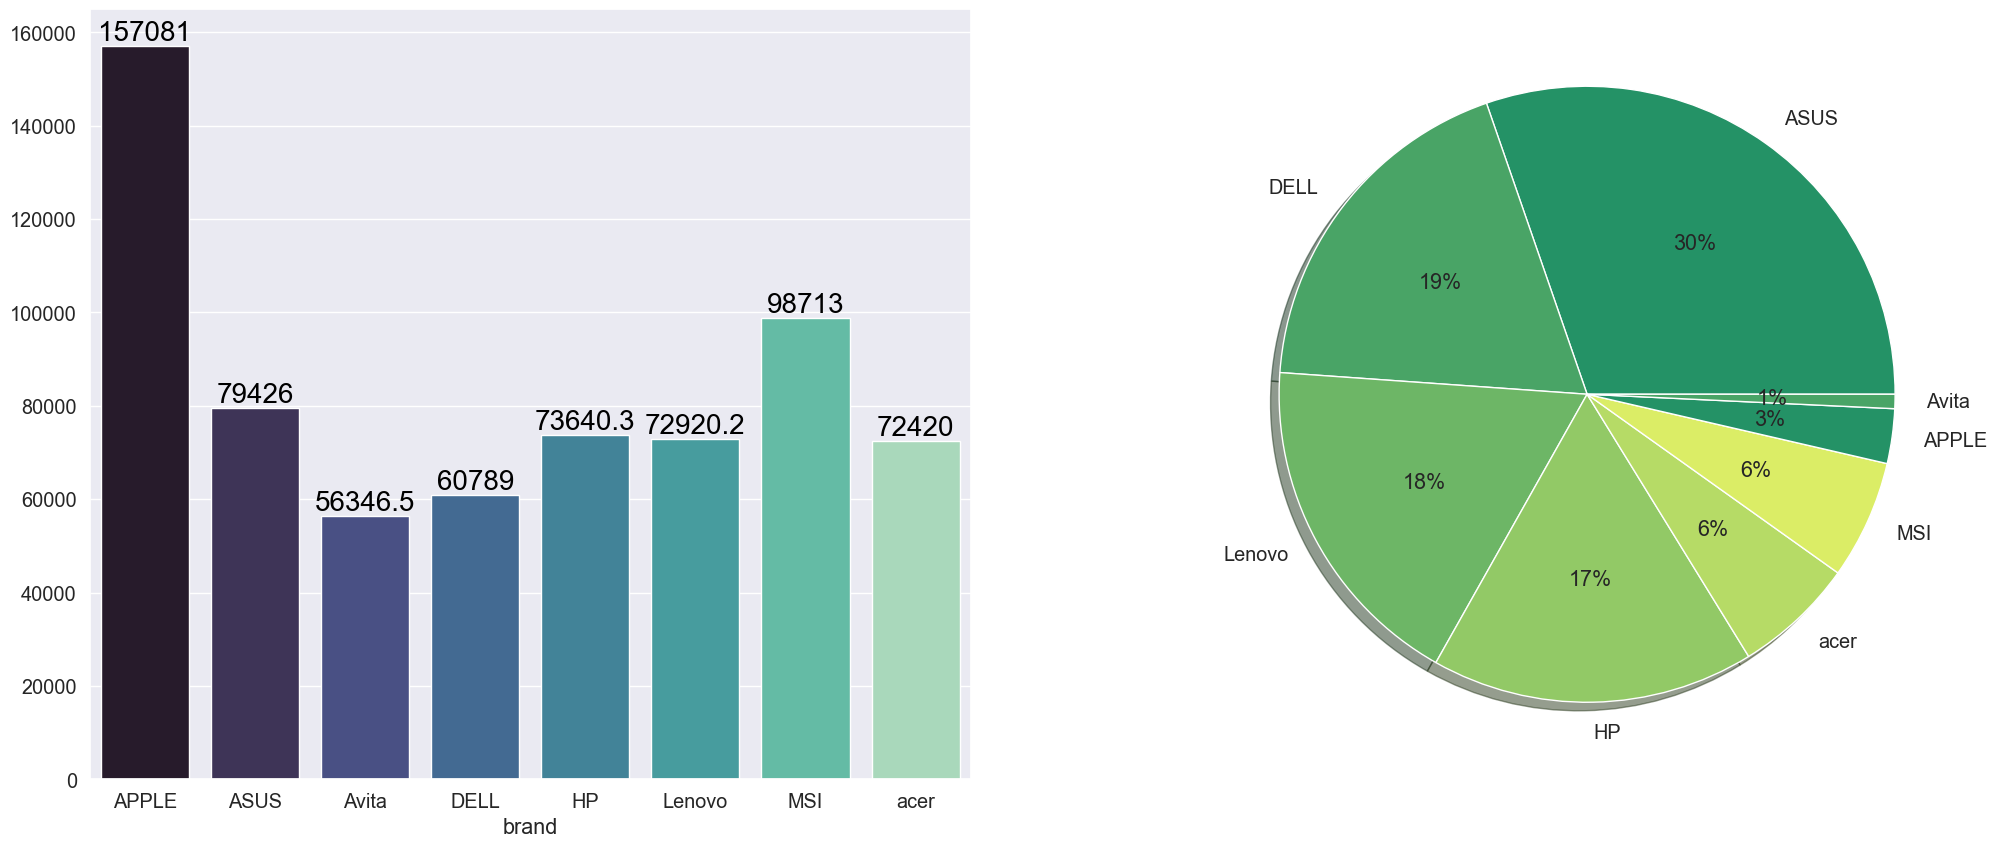

In [65]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('brand')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    
palette_color = sns.color_palette('summer')
plt.pie(x = df['brand'].value_counts(),labels=df['brand'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

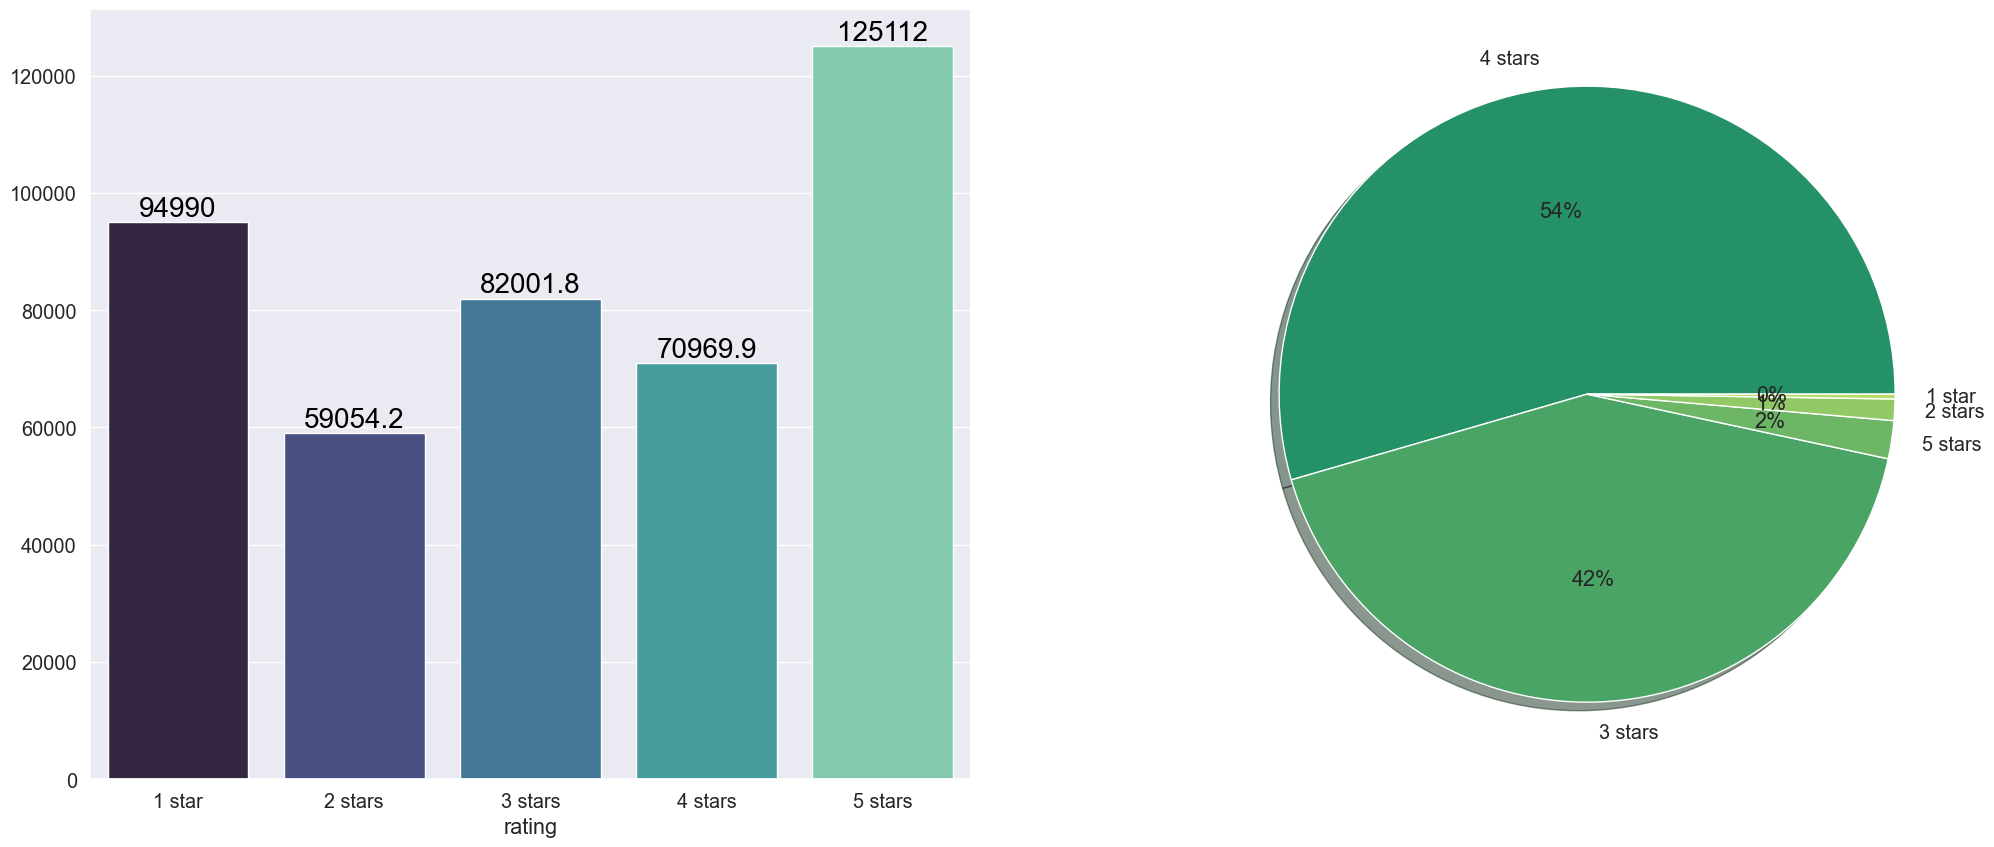

In [66]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('rating')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    
palette_color = sns.color_palette('summer')
plt.pie(x = df['rating'].value_counts(),labels=df['rating'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

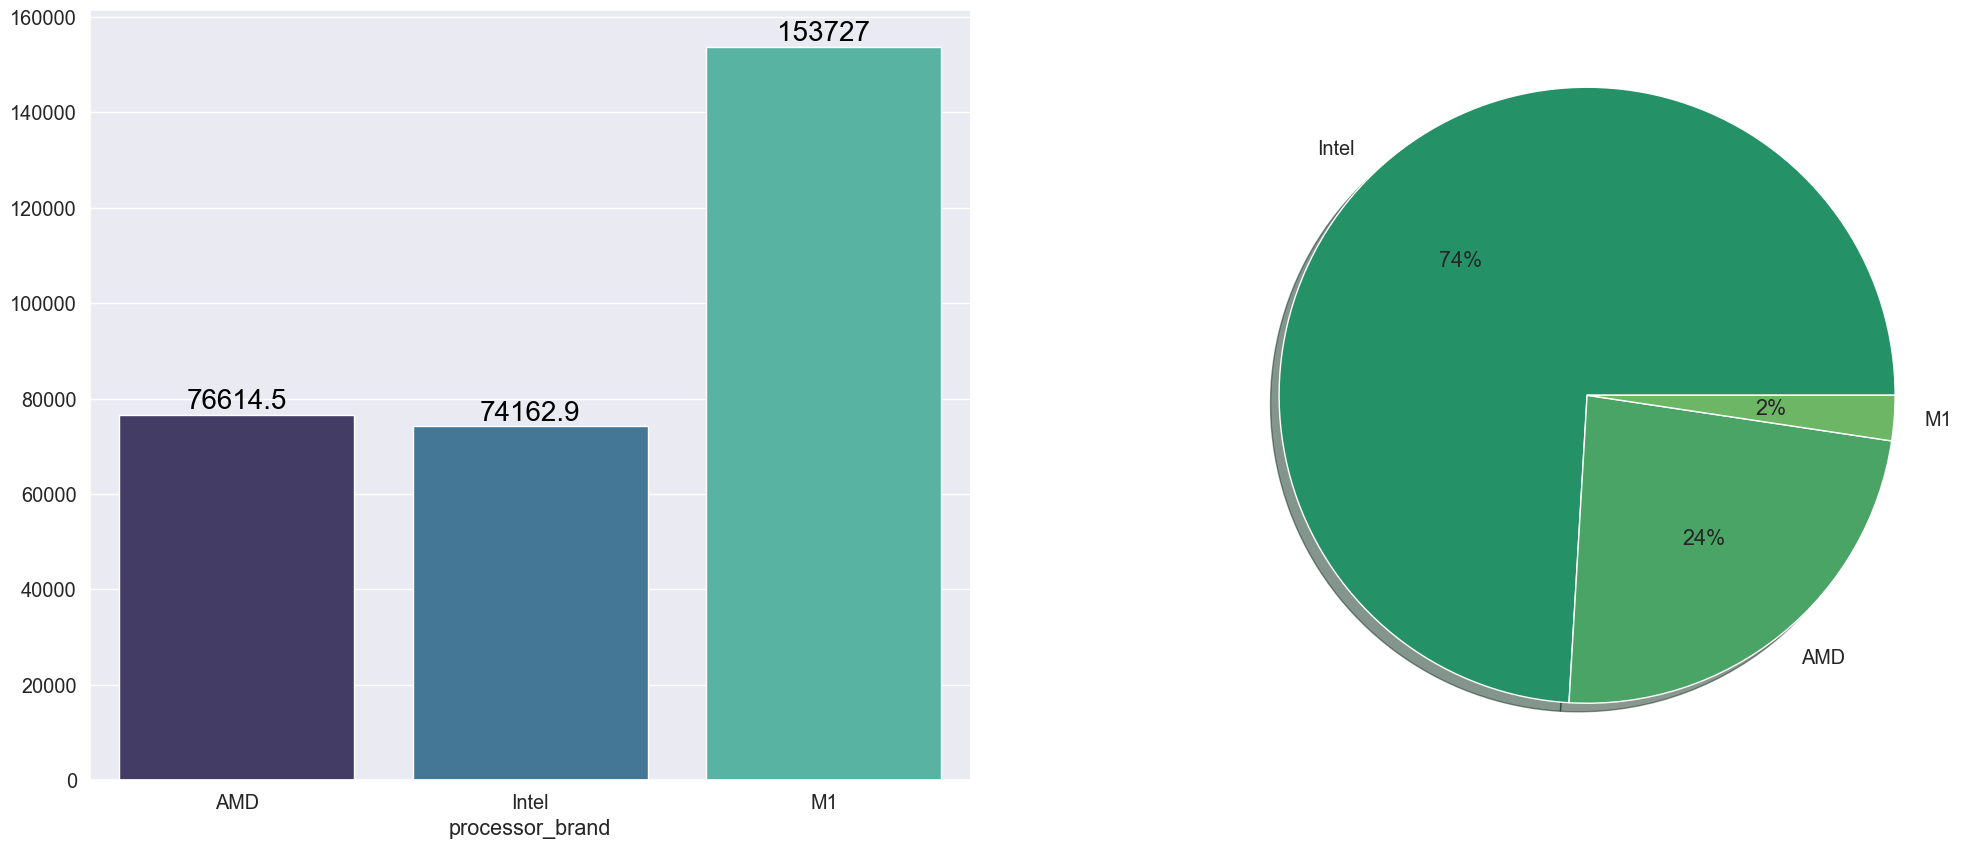

In [67]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('processor_brand')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    
palette_color = sns.color_palette('summer')
plt.pie(x = df['processor_brand'].value_counts(),labels=df['processor_brand'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

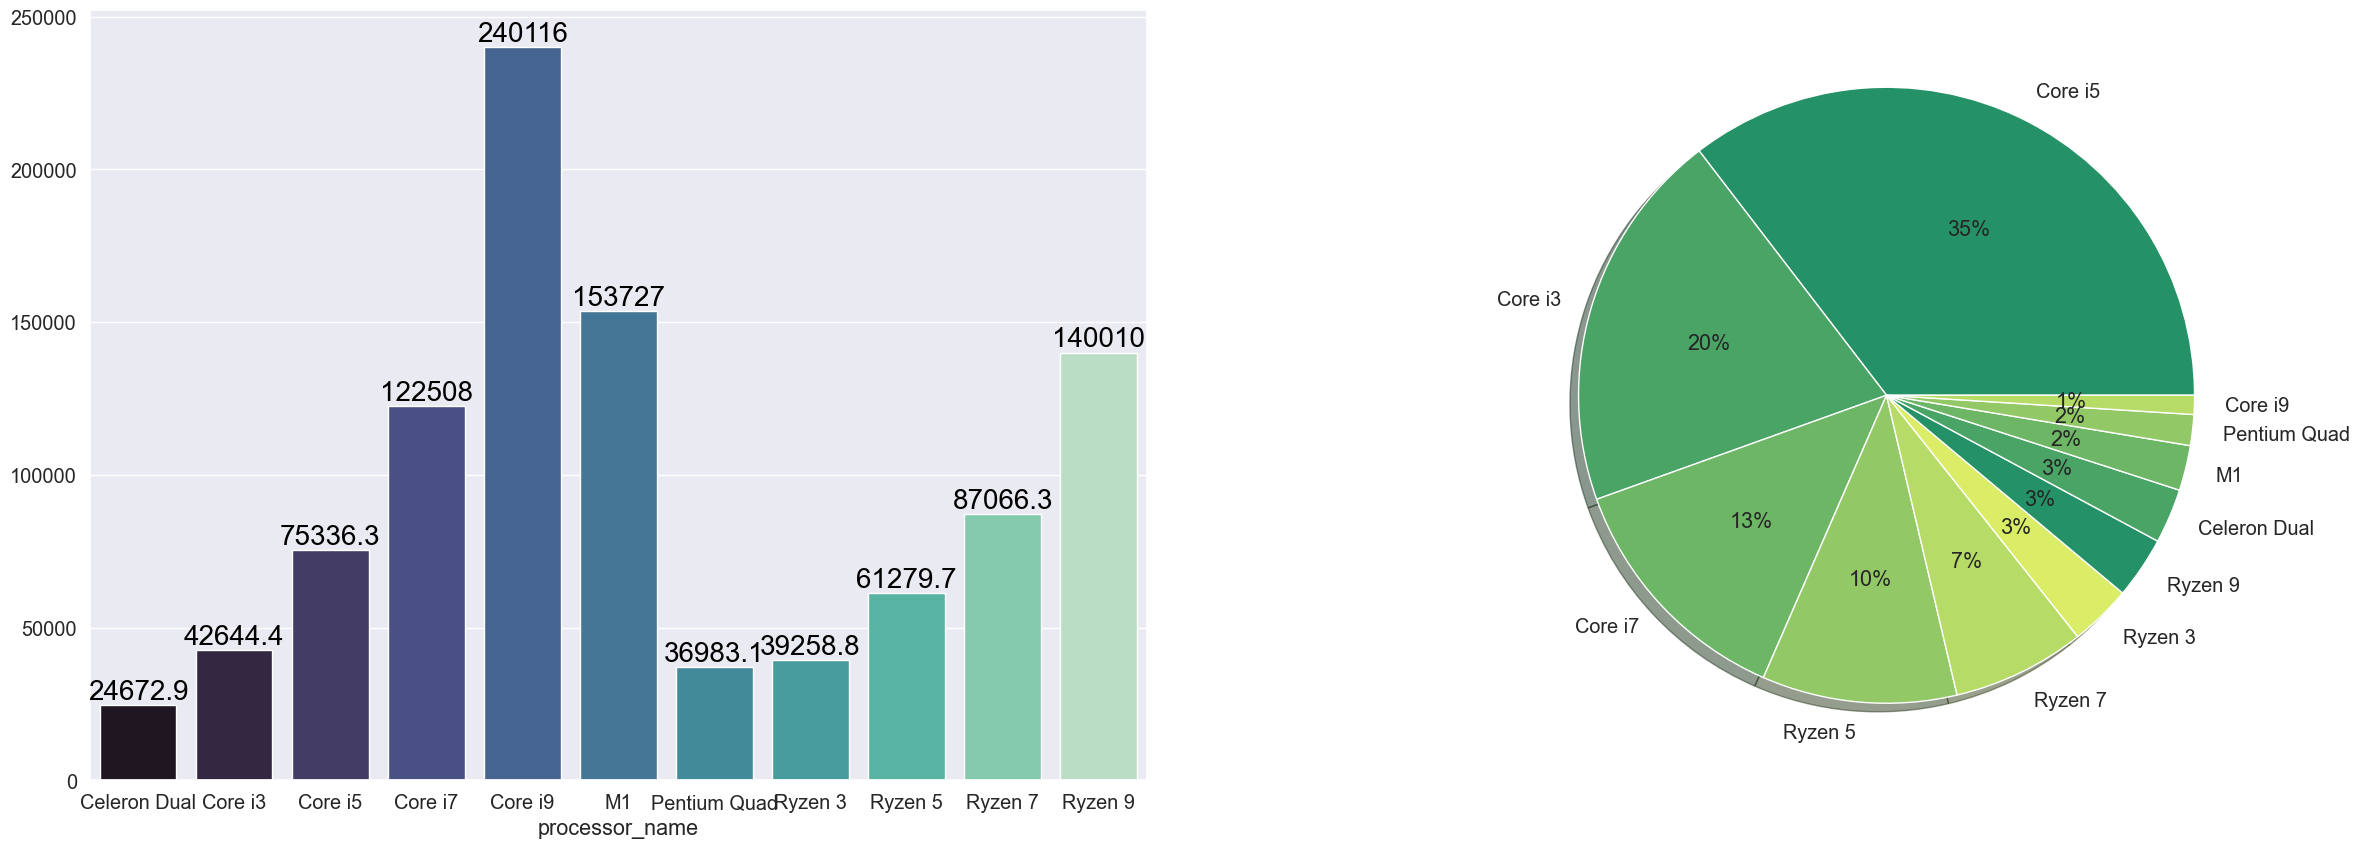

In [69]:
f,ax=plt.subplots(1,2,figsize=(30,10))
Group_data = df.groupby('processor_name')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    
palette_color = sns.color_palette('summer')
plt.pie(x = df['processor_name'].value_counts(),labels=df['processor_name'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

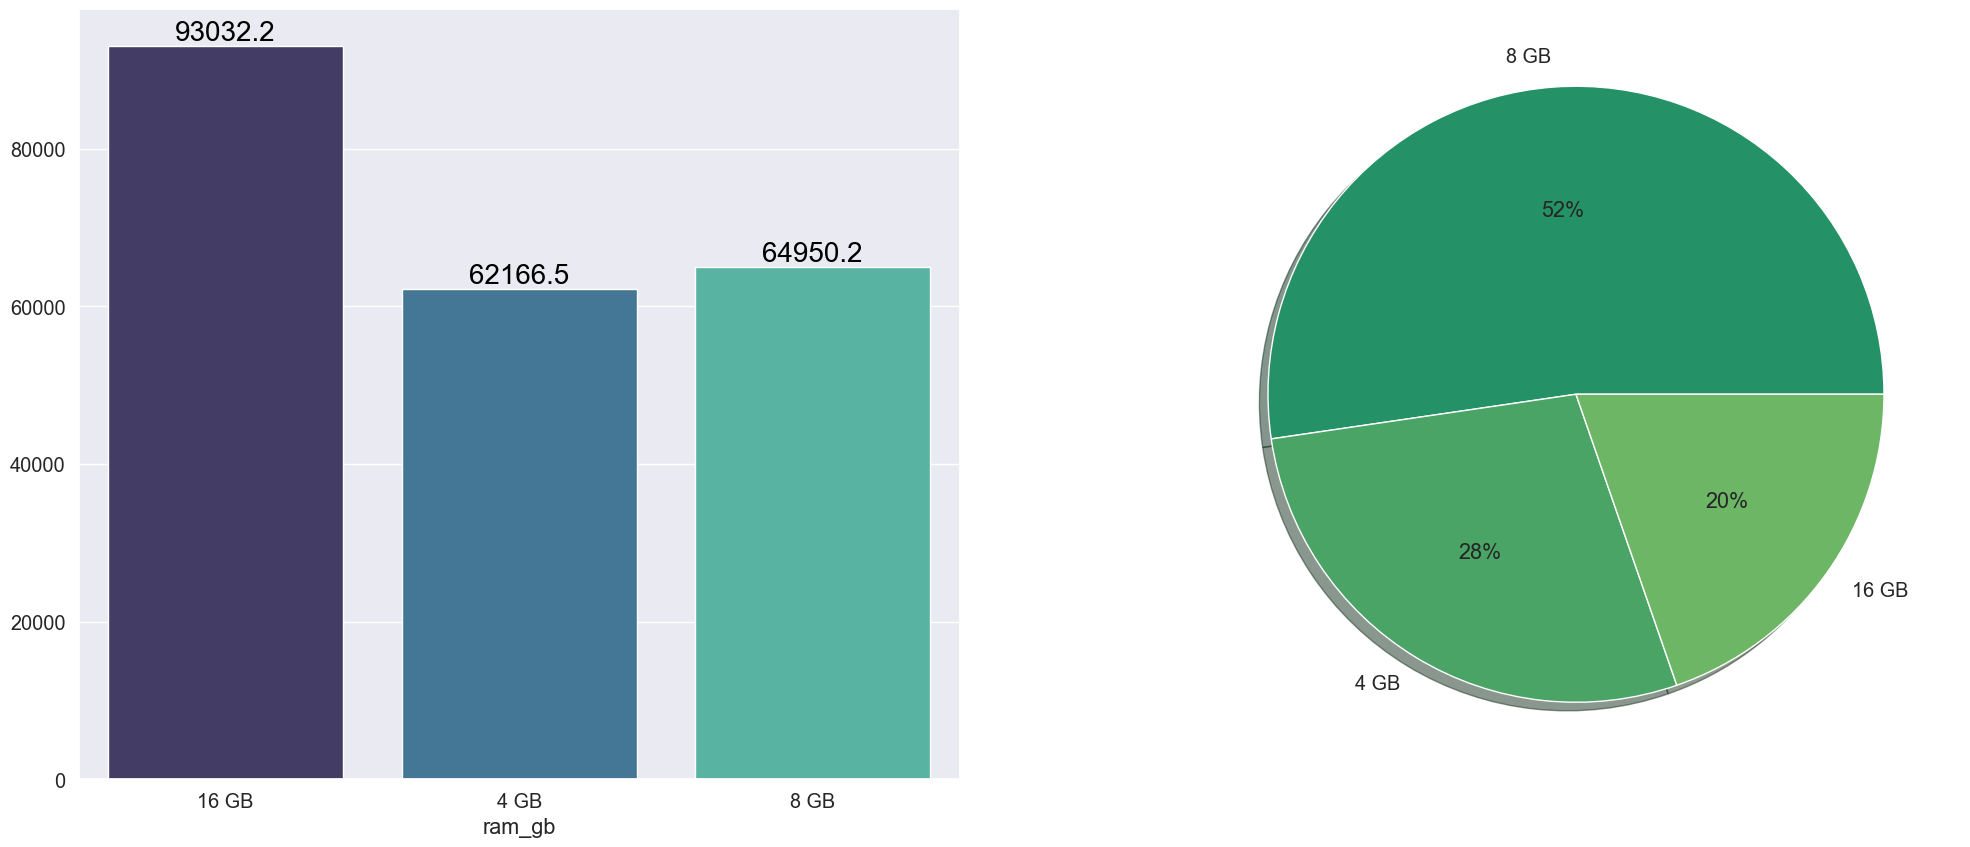

In [225]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('ram_gb')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    
palette_color = sns.color_palette('summer')
plt.pie(x = df['ram_gb'].value_counts(),labels=df['ram_gb'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

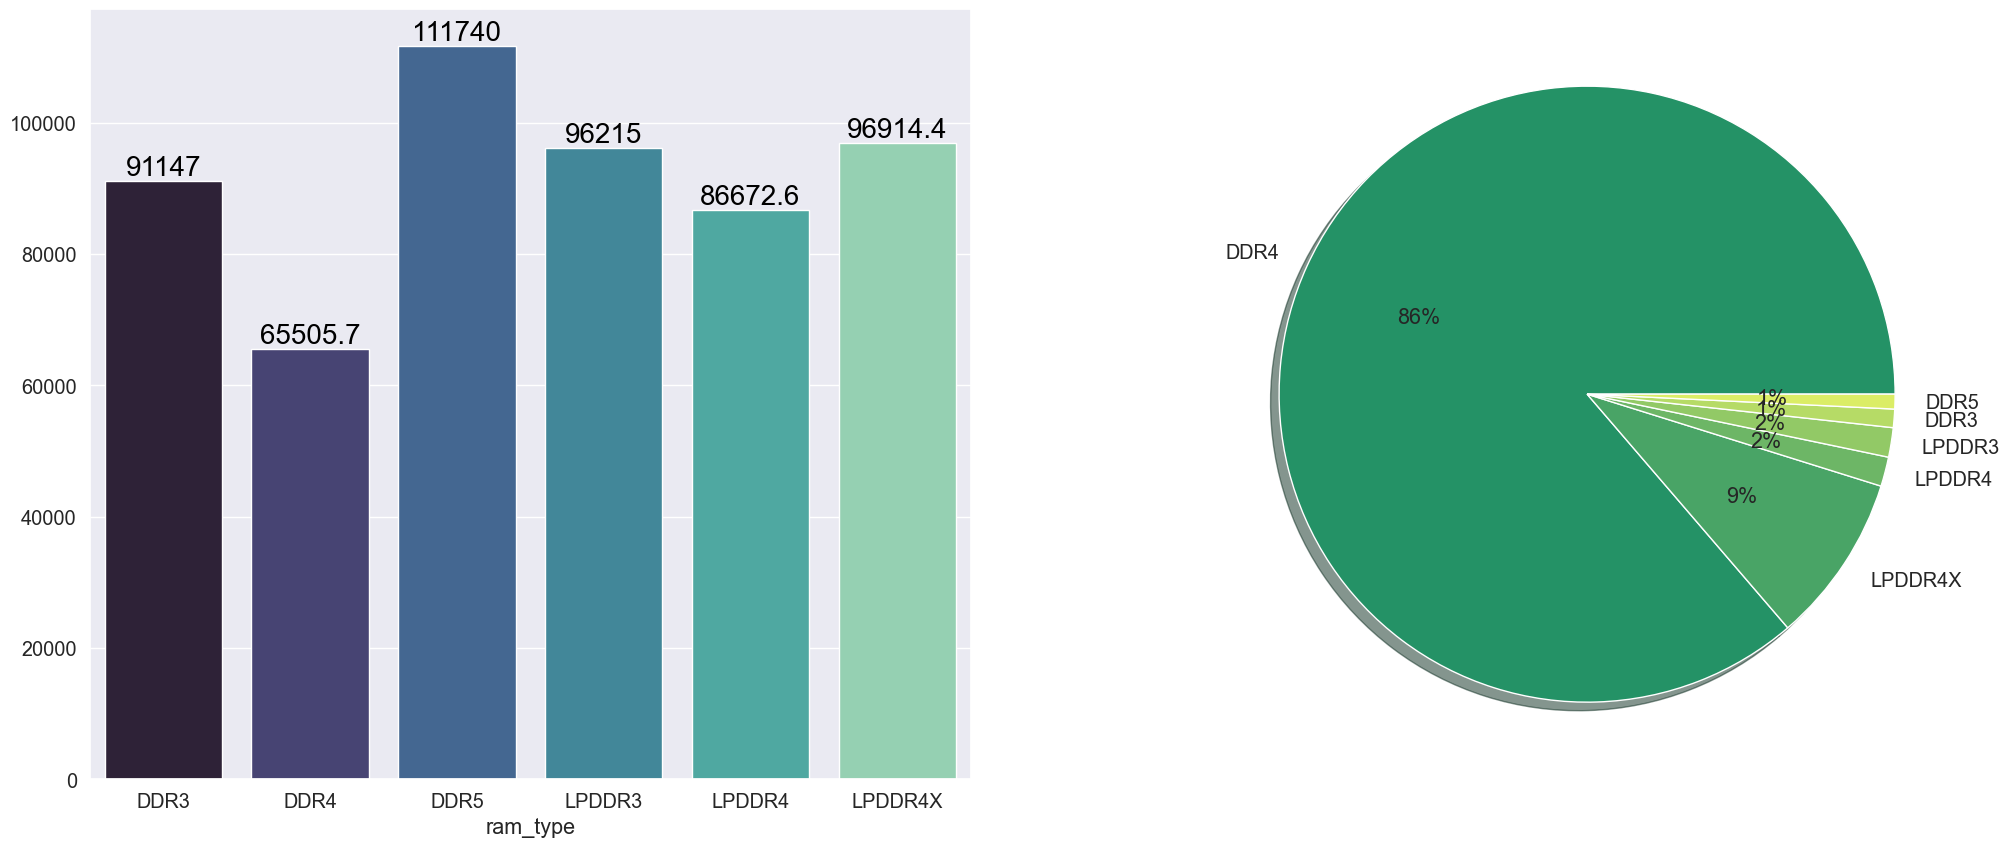

In [224]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('ram_type')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    
palette_color = sns.color_palette('summer')
plt.pie(x = df['ram_type'].value_counts(),labels=df['ram_type'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

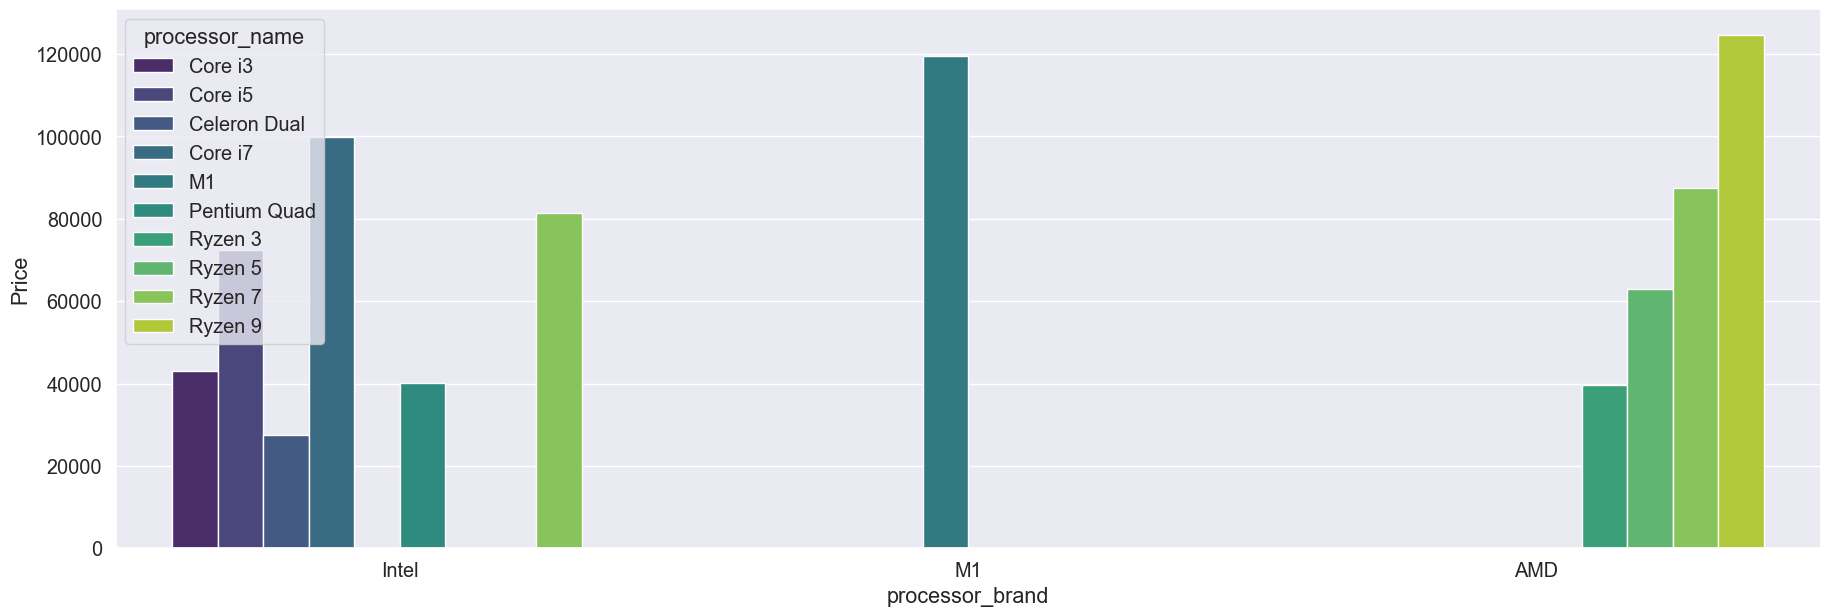

In [223]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=df['processor_brand'], 
                 y=df['Price'],
                 hue = df['processor_name'], 
                 palette='viridis',
                 ci = None)
plt.ylabel('Price');

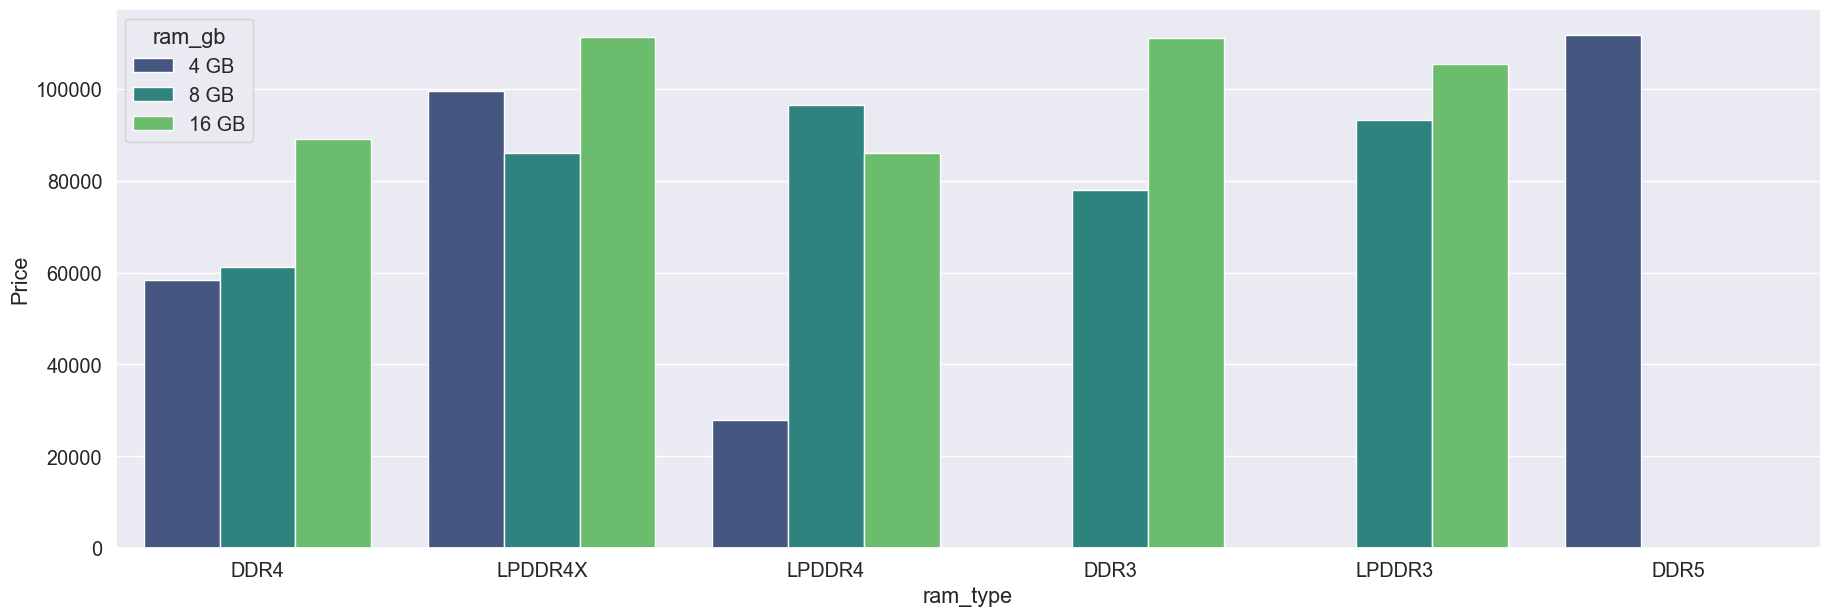

In [222]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=df['ram_type'], 
                 y=df['Price'],
                 hue = df['ram_gb'], 
                 palette='viridis',
                 ci = None)
plt.ylabel('Price');

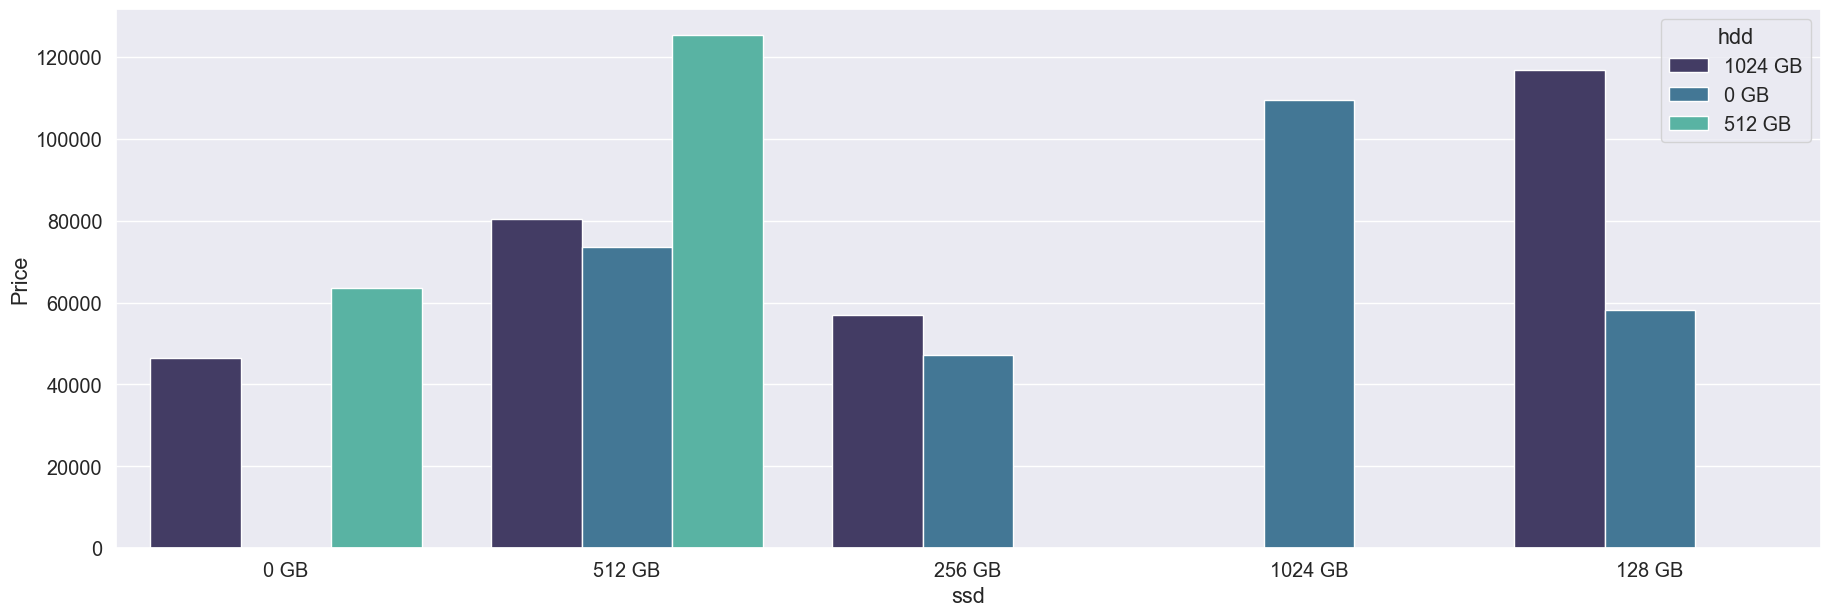

In [221]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=df['ssd'], 
                 y=df['Price'],
                 hue = df['hdd'], 
                 palette='mako',
                 ci = None)
plt.ylabel('Price');

### **4. Transformation Pipeline**

In [108]:
class LogScaling(BaseEstimator, TransformerMixin):

    def fit(self, X):
        return self   

    def transform(self, X):
        return np.log1p(X)

In [213]:
class TransformationPipeline:

    def __init__(self) -> None:
        pass
    
    def preprocess(self):
        cat_cols = df.select_dtypes('object').columns
        num_cols = ['Number of Ratings', 'Number of Reviews']

        num_pipeline= Pipeline(
            steps=[
            ("imputer",SimpleImputer(strategy="median")),
            ("scaler",StandardScaler())
            ]
        ) 

        cat_pipeline=Pipeline(
            steps=[
            ("imputer",SimpleImputer(strategy="most_frequent")),
            ("one_hot_encoder",OneHotEncoder()),
            ("scaler",StandardScaler(with_mean=False))
            ]
        )

        preprocessor = ColumnTransformer([
            ("log_transform", LogScaling(), num_cols),
            ("num_pipeline", num_pipeline, num_cols),
            ("cat_pipelines",cat_pipeline,cat_cols)
            ], remainder= 'passthrough')
        
        return preprocessor

In [214]:
X = df.drop('Price', axis = 1)
y = df.Price

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state= 1)
X_train.shape, X_test.shape

((466, 18), (52, 18))

In [216]:
preprocessor = TransformationPipeline().preprocess()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### **5. Modelling**

In [200]:
models = {
    'ridge' : Ridge(),
    'xgboost' : XGBRegressor(),
    'catboost' : CatBoostRegressor(verbose=0),
    'lightgbm' : LGBMRegressor(),
    'gradient boosting' : GradientBoostingRegressor(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'support vector': SVR(),
    'ada boost regressor': AdaBoostRegressor()
}

In [201]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')

ridge trained
xgboost trained
catboost trained
lightgbm trained
gradient boosting trained
lasso trained
random forest trained
support vector trained
ada boost regressor trained


In [217]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(79))
model.add(tf.keras.layers.Dense(200))
model.add(tf.keras.layers.Dense(200))
model.add(tf.keras.layers.Dense(200))
model.add(tf.keras.layers.Dense(1))

model.compile(
    loss = 'mse', 
    optimizer = tf.keras.optimizers.Adam(), 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

model.fit(X_train.toarray(), y_train, validation_data=(X_test.toarray(), y_test), epochs=50)

Epoch 1/50
15/15 [==============================] - 0s 10ms/step - loss: 5517366272.0000 - rmse: 74278.9766 - val_loss: 5676233216.0000 - val_rmse: 75340.7812
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 5221099008.0000 - rmse: 72257.1719 - val_loss: 4801494016.0000 - val_rmse: 69292.8125
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 3300934400.0000 - rmse: 57453.7578 - val_loss: 1220002688.0000 - val_rmse: 34928.5352
Epoch 4/50
15/15 [==============================] - 0s 4ms/step - loss: 993635648.0000 - rmse: 31521.9863 - val_loss: 598446016.0000 - val_rmse: 24463.1562
Epoch 5/50
15/15 [==============================] - 0s 4ms/step - loss: 654097280.0000 - rmse: 25575.3262 - val_loss: 520297504.0000 - val_rmse: 22810.0312
Epoch 6/50
15/15 [==============================] - 0s 4ms/step - loss: 516018432.0000 - rmse: 22716.0391 - val_loss: 413128544.0000 - val_rmse: 20325.5645
Epoch 7/50
15/15 [==============================] - 0s 4m

In [218]:
RMSE_ann = model.evaluate(X_test.toarray(), y_test)[1]
RMSE_ann

2/2 [==============================] - 0s 3ms/step - loss: 205582256.0000 - rmse: 14338.1396


14338.1396484375

In [205]:
results = {}
kf = KFold(n_splits= 10)

for name, model in models.items():
    result = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', cv= kf)))
    results[name] = result
    
results['ANN'] = RMSE_ann

In [206]:
for name, result in results.items():
    print(f"{name} : {round(result, 3)}")

ridge : 12824.649
xgboost : 11988.238
catboost : 11676.983
lightgbm : 13019.542
gradient boosting : 12032.865
lasso : 12892.159
random forest : 12222.623
support vector : 26766.627
ada boost regressor : 16468.953
ANN : 14164.913


In [207]:
results_df = pd.DataFrame(results, index=range(0,1)).T.rename(columns={0: 'RMSE'}).sort_values('RMSE', ascending=False)
results_df.T

,support vector,ada boost regressor,ANN,lightgbm,lasso,ridge,random forest,gradient boosting,xgboost,catboost
RMSE,26766.627079,16468.952517,14164.913086,13019.541702,12892.159163,12824.648937,12222.622986,12032.864709,11988.237679,11676.983048


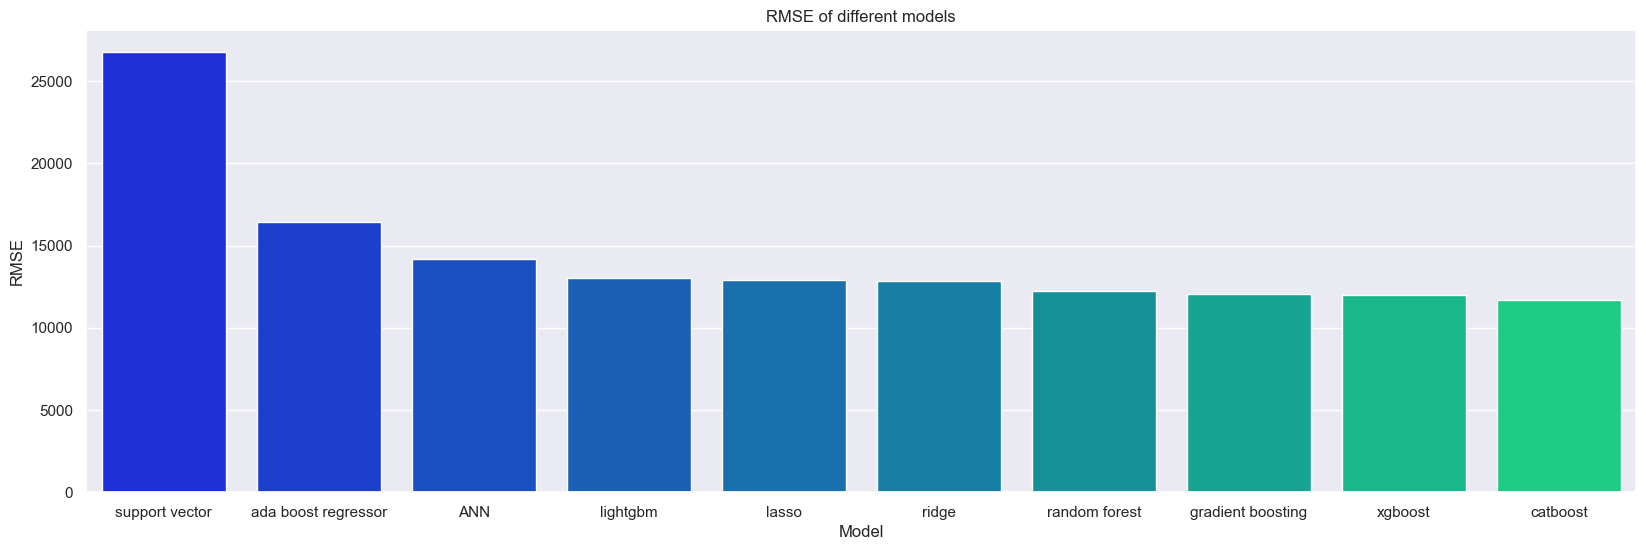

In [208]:
plt.figure(figsize = (20, 6))
sns.barplot(x= results_df.index, y = results_df['RMSE'], palette = 'winter')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of different models');

In [211]:
final_predictions = (
    0.25 * models['catboost'].predict(X_test) +
    0.25 * models['gradient boosting'].predict(X_test) +
    0.25 * models['random forest'].predict(X_test) + 
    0.25 * models['xgboost'].predict(X_test)
)

In [212]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, final_predictions))}')
print(f'R-square: {r2_score(y_test, final_predictions)}')

RMSE: 13866.868287976687
R-square: 0.7088773443392484


### **6. Evaluation**

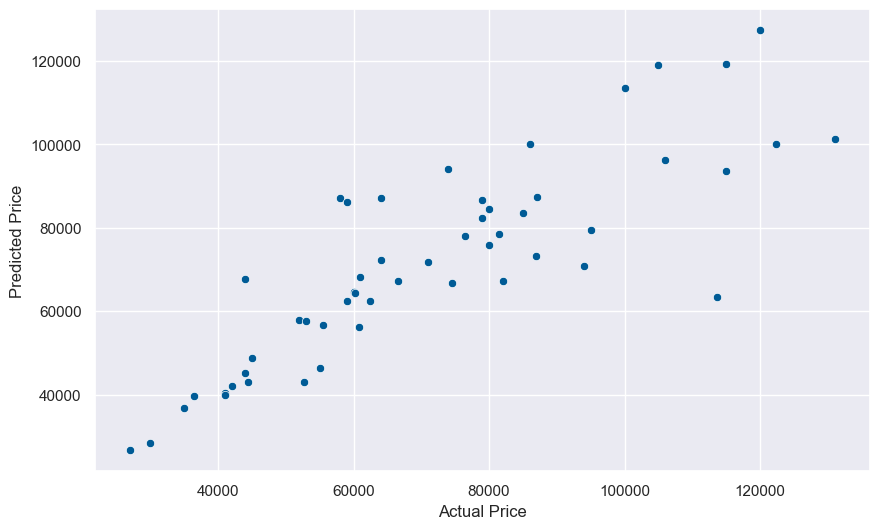

In [219]:
plt.figure(figsize= (10, 6))
sns.scatterplot(x= y_test, y= final_predictions, color= '#005b96')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

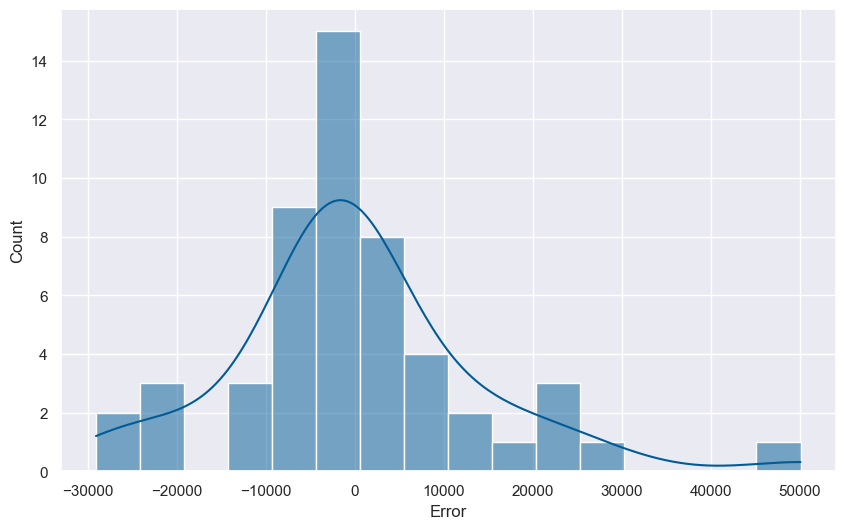

In [220]:
# Distribution of error
plt.figure(figsize = (10, 6))
sns.histplot(y_test - final_predictions, color = '#005b96', kde= True)
plt.xlabel('Error');